# CUSTOMER PURCHASE PREDICTION

## PROJECT DESCRIPTION

In this project, I will build a decision tree classifier to predict whether a customer will purchase a product or service based on their demographic and behavioral data. I will use a dataset from the UCI Machine Learning Repository, which contains information such as age, job, marital status, education, balance, and various other features about the customers. The goal is to develop a predictive model that can assist marketing efforts by identifying potential customers who are more likely to make a purchase

In [1]:
#pip install --upgrade scikit-learn


In [2]:
#pip install --upgrade imbalanced-learn scikit-learn


In [3]:
#pip install imbalanced-learn==0.7.0 scikit-learn==0.24.2


In [4]:
# import useful libraries 
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder  
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve,roc_auc_score,log_loss
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [5]:
#Initialize the DataUnderstanding class
class DataUnderstanding:
    def __init__(self, df):
        self.df = df
# Get the summary statistics
    def get_summary_statistics(self):
        summary_stats = self.df.describe()
        return summary_stats
# Get the count of missing values
    def get_missing_values(self):
        missing_values = self.df.isnull().sum()
        return missing_values
# Get the summary of the DataFrame   
    def get_info(self):
        info = self.df.info()
        return info
# Get the data types
    def get_dtypes(self):
        dtypes = self.df.dtypes
        return dtypes  
    
    def get_value_counts(self):
        value_counts = {}
        for column in self.df.columns:
            value_counts[column] = self.df[column].value_counts()
        return value_counts
    

In [6]:
# load the data
bank = pd.read_csv('bank-full.csv', delimiter=';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
# Initialize the DataUnderstanding class
dt = DataUnderstanding(bank)

# Get the summary statistics
du.get_summary_statistics()

In [8]:
# get summary of the data
dt.get_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [9]:
# Get data types
dt.get_dtypes()

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

## DATA PREPARATION

#### Check for missing values

In [10]:
# Replace 'unknown' with NaN for categorical columns
categorical_columns = ['job', 'marital', 'education', 'contact', 'poutcome', 'month']
bank[categorical_columns] = bank[categorical_columns].replace('unknown', pd.NA)

In [11]:
# Check for missing values
dt.get_missing_values()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

#### dealing with missing values
Job has a few missing values i can drop the rows with missing values

In [12]:
# Remove rows with missing ages
bank.dropna(subset=['job'], inplace=True)

 drop both the poutcome column and contact

In [13]:
bank = bank.drop(['poutcome', 'contact'], axis=1)

In [14]:
#I will fill the missing values in education with mode.This will help preserve data  and it will have minimal impact on the overall distribution of data
bank['education'].fillna(bank['education'].mode()[0], inplace=True)

In [15]:
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
y            0
dtype: int64

In [16]:
# get value counts
dt.get_value_counts()

{'age': 32    2084
 31    1990
 33    1964
 34    1926
 35    1887
       ... 
 88       2
 92       2
 93       2
 95       2
 94       1
 Name: age, Length: 77, dtype: int64,
 'job': blue-collar      9732
 management       9458
 technician       7597
 admin.           5171
 services         4154
 retired          2264
 self-employed    1579
 entrepreneur     1487
 unemployed       1303
 housemaid        1240
 student           938
 Name: job, dtype: int64,
 'marital': married     27011
 single      12722
 divorced     5190
 Name: marital, dtype: int64,
 'education': secondary    23131
 tertiary     13262
 primary       6800
 Name: education, dtype: int64,
 'default': no     44110
 yes      813
 Name: default, dtype: int64,
 'balance':  0        3486
  1         194
  2         155
  4         139
  3         131
           ... 
  7264        1
  4144        1
 -1085        1
  23592       1
  5709        1
 Name: balance, Length: 7142, dtype: int64,
 'housing': yes    25104
 no     1

In [17]:
#### Detecting outliers and removing outliers

In [18]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [19]:
# # Set the plot style to a dark theme
plt.style.use('classic')

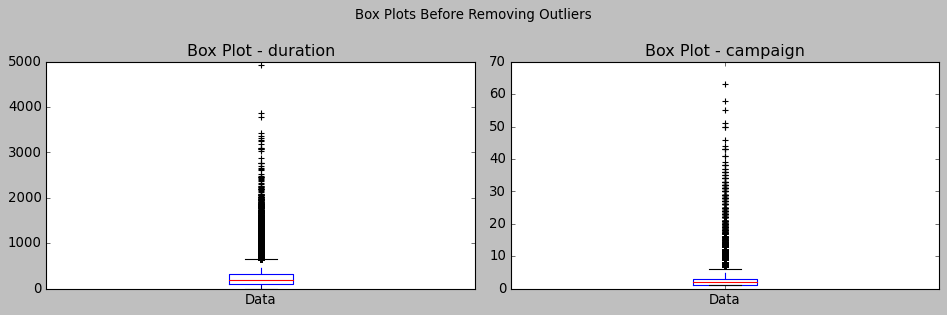

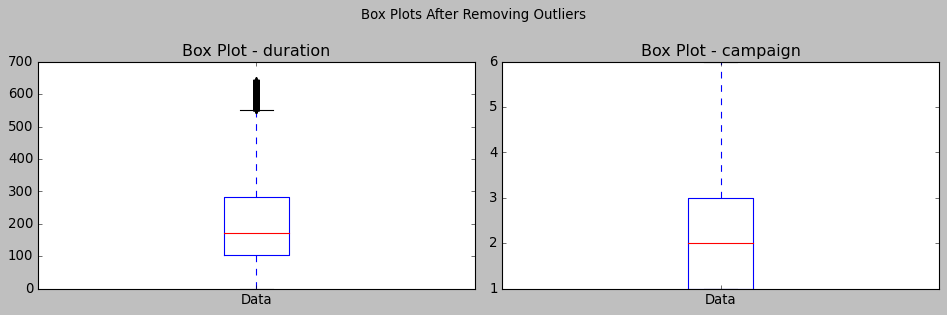

In [20]:
# plot
def plot_boxplots(data, column_names, title):
    plt.figure(figsize=(12, 4))
    for i, column in enumerate(column_names, 1):
        plt.subplot(1, len(column_names), i)
        plt.boxplot(data[column])
        plt.title(f'Box Plot - {column}')
        plt.xticks([1], ['Data'])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Specify the numeric columns you want to check for outliers
numeric_columns = ['duration', 'campaign']

# Plot box plots before removing outliers
plot_boxplots(bank, numeric_columns, 'Box Plots Before Removing Outliers')

def remove_outliers_iqr(df, column_names):
    outliers_removed = df.copy()
    for column in column_names:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Detect and remove outliers
        outliers_removed = outliers_removed[(outliers_removed[column] >= lower_bound) &
                                              (outliers_removed[column] <= upper_bound)]

    return outliers_removed

# Detect and remove outliers
bank = remove_outliers_iqr(bank, numeric_columns)

# Plot box plots after removing outliers
plot_boxplots(bank, numeric_columns, 'Box Plots After Removing Outliers')


# EXPLORATORY DATA ANALYSIS

### Univariate Analysis

Univariate analysis involves examining the distribution of individual variables

#### Subscription rate

The dependent variable would typically be "y," which represents whether the customer subscribed to a term deposit. This variable indicates the binary outcome of interest: whether a customer made a specific decision or took a specific action, in this case, subscribing to a term deposit or not

In [21]:
# count of subscription rate
bank['y'].value_counts(normalize=True)

no     0.90895
yes    0.09105
Name: y, dtype: float64

The distribution of the two classes in the data set is not equal. This causes data imbalance. Data imbalance can cause a model to make false predictions, so it is important to address this issue before modeling.

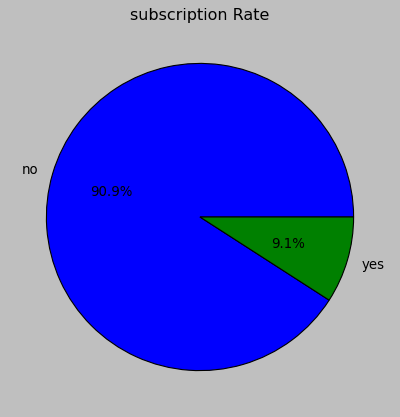

In [22]:
#plotting churn rate
def plot_churn_rate(data):
    #Create a figure
    fig, ax = plt.subplots()

    # Plot the churn rate
    ax.pie(bank['y'].value_counts(), labels=bank['y'].value_counts().index, autopct='%1.1f%%')

    # Add a title
    ax.set_title('subscription Rate')

    # Show the plot
    plt.show()
plot_churn_rate(bank['y']) 

* Approximately 90.9% of the customers did not subscribe to a term deposit, while the remaining did subscribe.  
* Knowing that only a small percentage of customers subscribed, marketing campaigns could focus on identifying and targeting specific customer segments that are more likely to subscribe

#### Duration Distribution Analysis

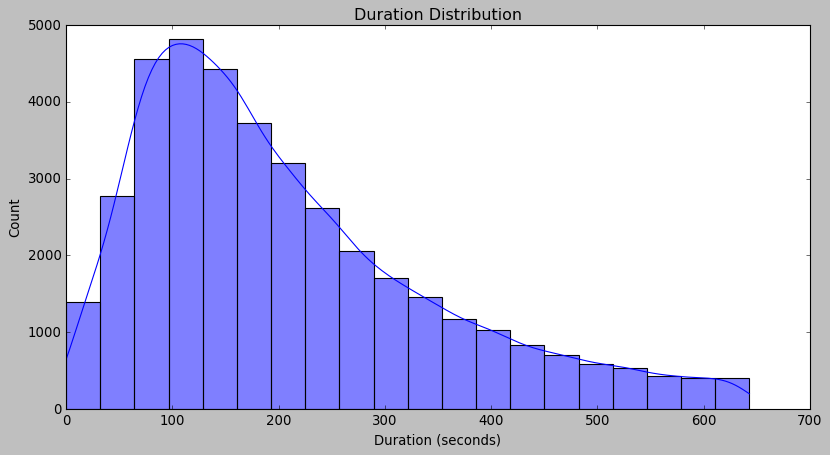

In [23]:
# plot
plt.figure(figsize=(12, 6))
sns.histplot(bank['duration'], bins=20, kde=True)
plt.title('Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

* Right-Skewed Distribution: The duration distribution is right-skewed, indicating that most customer interactions have shorter durations, with a few exceptionally long durations. 
* Peak at Short Durations: The peak of the distribution is at shorter call durations, suggesting that the majority of customer interactions are relatively brief.  
* Long Call Durations: There are significant outliers on the right side, representing a minority of customer interactions with very long call durations.
* Potential Significance: Longer call durations may indicate more in-depth conversations, potentially related to successful subscription outcomes. It's worth exploring whether longer durations correlate with higher subscription rates.
* Based on this distribution, it may be beneficial to tailor communication strategies for shorter and longer call durations. Shorter calls could focus on concise messaging, while longer calls might involve more detailed discussions.

#### Job Analysis

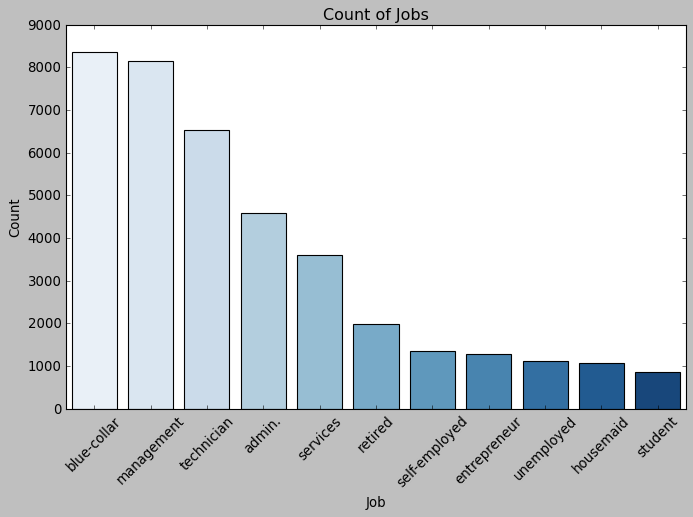

In [24]:
# Define a color palette with shades of blue
blue_palette = sns.color_palette("Blues", n_colors=len(bank['job'].unique()))
# plot
plt.figure(figsize=(10, 6))
sns.countplot(data=bank, x='job', order=bank['job'].value_counts().index, palette=blue_palette)
plt.title('Count of Jobs')
plt.xlabel('Job')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

* Most Common Jobs: The most common jobs among customers include "blue-collar," "management," "technician," and "admin"
* Imbalanced Job Categories: Some job categories are imbalanced, with a significantly larger number of customers in certain occupations compared to others.
* Marketing strategies can be tailored based on job categories. For instance, promotions or messaging can be customized to appeal to specific professional groups.


### Bivariate Analysis

#### Subscription Rate by Education

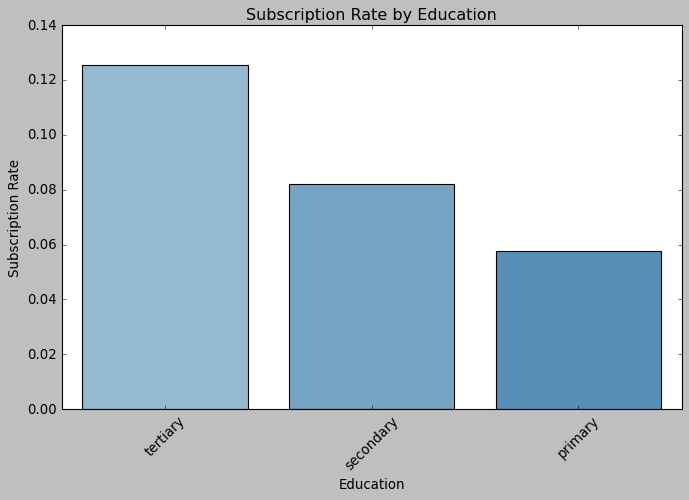

In [25]:
# Define a custom color palette with darker shades of blue
custom_palette = sns.color_palette("Blues_d")
# Pivot table to examine the relationship between education and subscription (y)
pivot_table = bank.pivot_table(index='education', columns='y', values='age', aggfunc='count', fill_value=0)
pivot_table['subscription_rate'] = pivot_table['yes'] / (pivot_table['yes'] + pivot_table['no'])

# Bar plot to visualize subscription rate by education
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_table, x=pivot_table.index, y='subscription_rate', order=pivot_table.sort_values(by='subscription_rate', ascending=False).index, palette=custom_palette)
plt.title('Subscription Rate by Education')
plt.xlabel('Education')
plt.ylabel('Subscription Rate')
plt.xticks(rotation=45)
plt.show()


* Customers with a "tertiary" education  have the highest subscription rate, indicating that individuals with higher education levels are more likely to subscribe to the term deposit 
* Followed by those with "secondary" education status.
* In contrast, customers with a "primary" education level have the lowest subscription rate.This group may require more targeted and persuasive marketing efforts to increase their subscription rates
* To improve subscription rates, marketing strategies could be adjusted to target customers with higher education levels more effectively. Tailoring campaigns or promotions to appeal to customers with "tertiary" education might be a successful approach



In [26]:
#### Age vs. Subscription (y)

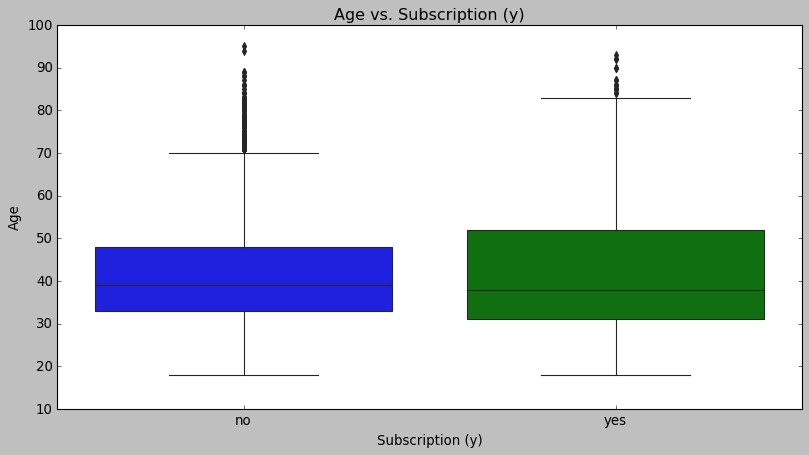

In [27]:
# Bivariate analysis with respect to the target variable ("y")
plt.figure(figsize=(12, 6))
sns.boxplot(data=bank, x='y', y='age')
plt.title('Age vs. Subscription (y)')
plt.xlabel('Subscription (y)')
plt.ylabel('Age')
plt.show()


- Customers who subscribed to the term deposit ("yes") tend to have a slightly higher median age compared to those who did not subscribe ("no").
- The age distribution for both "yes" and "no" categories has some overlap. However, there are more outliers (individual points outside the whiskers) in the "yes" category, suggesting that there might be a greater variation in age among customers who subscribed.
- Age alone may not be the sole determinant of subscription behavior, but it appears to have some influence. Older customers might be slightly more inclined to subscribe, while younger customers might have a broader range of subscription behaviors.

#### Subscription by Campaign

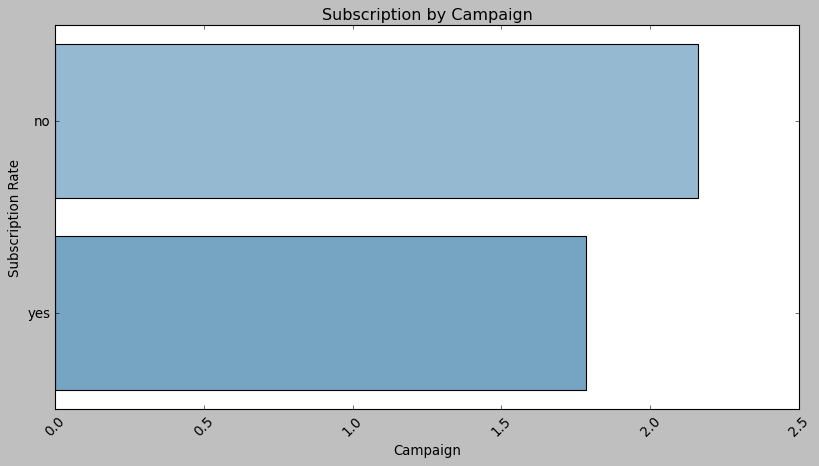

In [28]:
# plot
plt.figure(figsize=(12, 6))
sns.barplot(data=bank, x='campaign', y='y', ci=None, palette=custom_palette)
plt.title('Subscription by Campaign')
plt.xlabel('Campaign')
plt.ylabel('Subscription Rate')
plt.xticks(rotation=45)
plt.show()

* Decreasing Subscription Rate: As the number of campaign contacts increases, the subscription rate tends to decrease. This suggests that repeatedly contacting a customer during a campaign may have diminishing returns and could potentially be seen as intrusive 
* To improve subscription rates, marketers should consider optimizing their campaign strategies. Instead of increasing the number of contacts, they could concentrate on tailoring their messages and interactions to be more compelling and relevant to the custome


### Multivariate Analysis

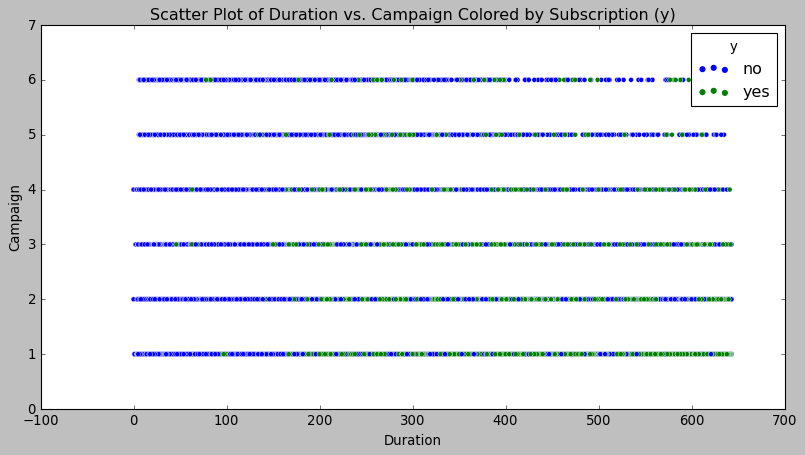

In [29]:
#### Scatter Plot of Duration vs. Campaign Colored by Subscription
# plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=bank, x='duration', y='campaign', hue='y')
plt.title('Scatter Plot of Duration vs. Campaign Colored by Subscription (y)')
plt.xlabel('Duration')
plt.ylabel('Campaign')
plt.show()

* The plot shows a general trend where longer "Duration" of the last contact tends to be associated with a lower "Campaign" number. In other words, customers who subscribed to the term deposit ("y" = yes) tend to have shorter campaign interactions (fewer contacts) and longer last contact durations
* The plot indicates that a marketing strategy that focuses on shorter and more effective interactions during the last contact may be more successful in achieving subscriptions. It's essential to identify and target customers within the subscriber cluster
* Too many campaign contacts with short durations may not be as effective in achieving subscriptions

#### Pairwise Scatter Plots

In [30]:
# Select the numerical columns for the plot
columns = ['balance', 'duration', 'campaign', 'previous']

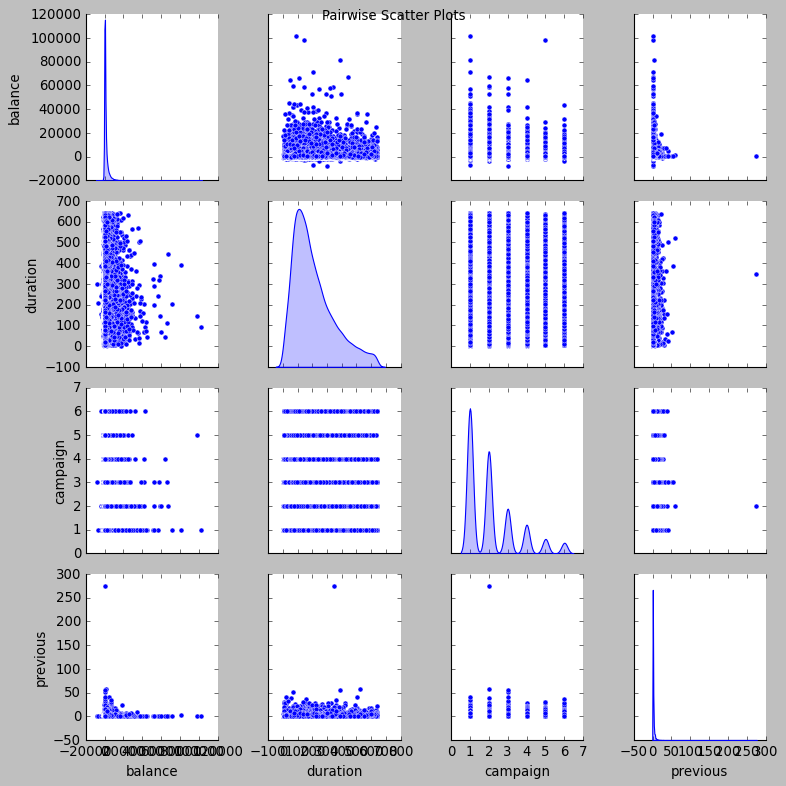

In [31]:
# Pairwise scatter plots for numerical variables
sns.pairplot(data=bank[columns], diag_kind='kde')
plt.suptitle('Pairwise Scatter Plots')
plt.show()

* Balance vs. Duration: No strong relationship observed. Balance alone doesn't predict contact duration.
* Balance vs. Campaign: No clear link between balance and campaign contacts.
* Balance vs. Previous: Balance isn't a reliable indicator of prior campaign interactions.
* Duration vs. Campaign: Longer contact durations are linked to fewer campaign contacts.
* Duration vs. Previous: No strong correlation between duration and prior campaign contacts.
* Balance and duration alone don't predict campaign success. 

In [32]:
#### Correlation matrix

In [33]:
# Select numerical columns for correlation 
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

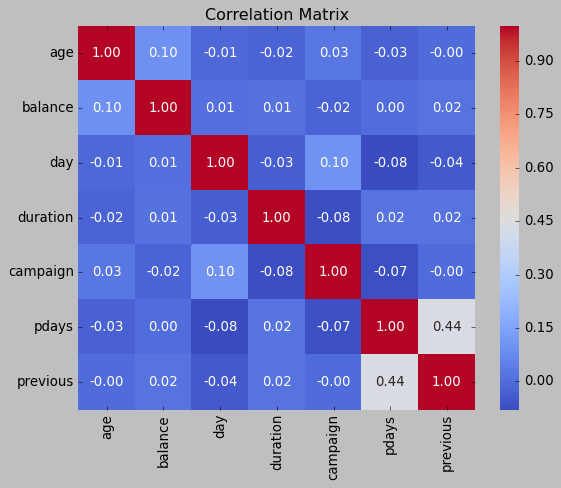

In [34]:
# Correlation matrix for numerical variables
correlation_matrix = bank[numerical_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

* Duration and Previous Contacts: Positive correlation, indicating longer past conversations may lead to more prior interactions.
* Duration and Campaign: Negative correlation, implying longer conversations may result in fewer follow-up contacts during the same campaign.
* Previous Contacts and Campaign: Mild positive correlation, suggesting customers with more prior interactions tend to have more contacts in the current campaign.
* Pdays and Previous Contacts: Weak negative correlation, hinting that customers contacted more in the past tend to have shorter intervals between contacts.

#### DATA PREPROCESSING'
##### Check for multicollinearity

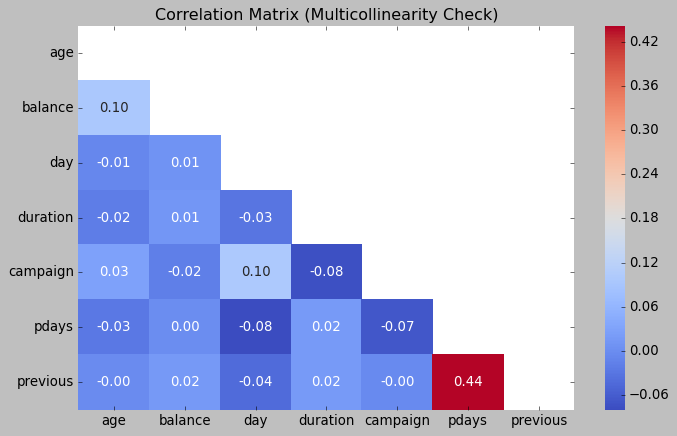

In [35]:
# Calculate the correlation matrix
correlation_matrix = bank[numerical_columns].corr()

# Create a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)

# Set plot title
plt.title('Correlation Matrix (Multicollinearity Check)')

# Show the plot
plt.show()


The variables are not highly correlated with each other hence no multicollinearity

In [36]:
### Convert  Column y to numeric(0s and 1s)
#The y feature need to be binary encoded to be used in the classification problem

In [37]:
# Convert binary categorical columns to numeric (yes/no to 1/0)
bank['y'] = bank['y'].map({'no': 0, 'yes': 1})


In [38]:
# display values in y
bank.y.unique()

array([0, 1], dtype=int64)

##### Assign the variables
assigning  target variable to y for prediction and the rest of the Features to independebt variable X

In [39]:
# Assign the data to X and y
y = bank['y']
X = bank.drop(columns=['y'], axis=1)

In [40]:
X.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0
3,47,blue-collar,married,secondary,no,1506,yes,no,5,may,92,1,-1,0
5,35,management,married,tertiary,no,231,yes,no,5,may,139,1,-1,0


### One-hot encode the categorical features
One-hot encoding converts categorical variables into binary vectors, where each category becomes a separate binary feature.This is necessary step in order to build a classification model

In [41]:
categorical_columns = ['job', 'marital', 'education', 'month', 'housing', 'loan', 'default']

In [42]:
# Onehotencode
ohe = OneHotEncoder(sparse=False)
X_categorical_encoded = ohe.fit_transform(X[categorical_columns])
# Retrieve feature names for the encoded columns
feature_names = []
for i, col in enumerate(categorical_columns):
    categories = ohe.categories_[i]
    for category in categories:
        feature_names.append(f"{col}_{category}")
# Create a DataFrame for the encoded features
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=feature_names)
X_categorical_encoded_df

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_may,month_nov,month_oct,month_sep,housing_no,housing_yes,loan_no,loan_yes,default_no,default_yes
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38842,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
38843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
38844,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
38845,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


### Scaling the numerical features

Scaling the numerical features is an essential preprocessing step before applying SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance in the dependent variable. Scaling ensures that numerical features are in the same range, making them directly comparable. This is crucial because SMOTE generates synthetic samples to balance the classes, and we want these synthetic samples to be consistent with the original data. Scaling prevents the introduction of unnecessary bias by ensuring that both original and synthetic samples exist within the same scaled range. Therefore, scaling is recommended before utilizing SMOTE to create a balanced dataset for modeling.

In [43]:
# Select the numerical columns to be scaled
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create a StandardScaler object
scaler = MinMaxScaler()
X_numeric_scaled = scaler.fit_transform(X[numerical_columns])

# Create a DataFrame for the scaled features
X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numerical_columns)

In [44]:
X_numeric_scaled_df.head()

,age,balance,day,duration,campaign,pdays,previous
0,0.519481,0.092259,0.133333,0.405910,0.0,0.0,0.0
1,0.337662,0.073067,0.133333,0.234837,0.0,0.0,0.0
2,0.194805,0.072822,0.133333,0.118196,0.0,0.0,0.0
3,0.376623,0.086476,0.133333,0.143079,0.0,0.0,0.0
4,0.220779,0.074901,0.133333,0.216174,0.0,0.0,0.0


In [45]:
# combine the scaled columns and onehotencoded columns
X_final = pd.concat([X_numeric_scaled_df, X_categorical_encoded_df, ], axis=1)
X_final

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,housing_no,housing_yes,loan_no,loan_yes,default_no,default_yes
0,0.519481,0.092259,0.133333,0.405910,0.0,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.337662,0.073067,0.133333,0.234837,0.0,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.194805,0.072822,0.133333,0.118196,0.0,0.000000,0.000000,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.376623,0.086476,0.133333,0.143079,0.0,0.000000,0.000000,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.220779,0.074901,0.133333,0.216174,0.0,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38842,0.714286,0.098678,0.533333,0.466563,0.0,0.047018,0.029091,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
38843,0.090909,0.077388,0.533333,0.600311,0.2,0.000000,0.000000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
38844,0.688312,0.088501,0.533333,0.709176,0.2,0.000000,0.000000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
38845,0.506494,0.078868,0.533333,0.790047,0.6,0.000000,0.000000,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [46]:
### Train-Test Split  
#I will split the data in 80% training and 20% testing data
# Perform train test split using sci kit learn train_test_split
X_train , X_test, y_train, y_test = train_test_split(X_final, y, test_size =0.2, random_state=1)

### SMOTE

Synthetic Minority Over-sampling Technique is used to handle imbalanced distribution of the target variable

In [47]:
y.value_counts()

0    35310
1     3537
Name: y, dtype: int64

In [48]:
#I will use smote to resolve the imbalance in the target variable above where 1 has very few samples compared to 0.

# instantiate SMOTE 
sm = SMOTE(random_state=1)
# fit sm on the training data
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
# print training data set before over sampling
print('Before resampling, the shape of X_train: {}'.format(X_train.shape))
print('Before resampling, the shape of y_train: {}'.format(y_train.shape)) 
# print training data set after over sampling
print('After resampling, the shape of X_train_resampled: {}'.format(X_train_resampled.shape))
print('After resampling, the shape of y_train_resampled: {}'.format(y_train_resampled.shape))
y_train_resampled.value_counts()

Before resampling, the shape of X_train: (31077, 42)
Before resampling, the shape of y_train: (31077,)
After resampling, the shape of X_train_resampled: (56422, 42)
After resampling, the shape of y_train_resampled: (56422,)


0    28211
1    28211
Name: y, dtype: int64

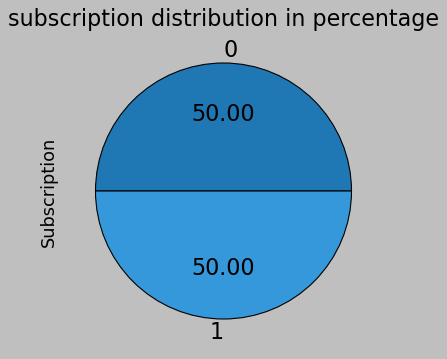

In [49]:
# pie chart showing distribution of target variable
fig, ax = plt.subplots(figsize=(10, 5))
#plot pie chart
y_train_resampled.value_counts().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 20}, colors=['#1f77b4', '#3498db'], ax=ax)
# plot labels
ax.set_ylabel('Subscription', fontsize=16)
ax.set_title('subscription distribution in percentage', fontsize=20);

The training data is balanced

## MODEL

### Baseline Model - Decision Tree Classifier

In [50]:
# Instantiate the model
dt_classifier = DecisionTreeClassifier(random_state=1)

# fit the model on the training data
dt_classifier.fit(X_train_resampled, y_train_resampled) 

# predict on the test data
y_test_pred_dt = dt_classifier.predict(X_test)

# predict on the training data 
y_train_pred_dt = dt_classifier.predict(X_train_resampled)

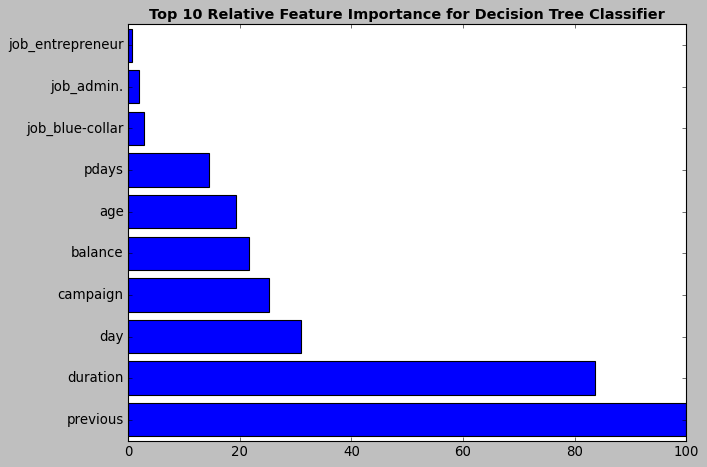

In [51]:
# function to plot
def plot_top_feature_importance_tree(feature_importance, feature_names, top_n=10, model_name=None):
    # Sort feature importances and select the top N
    sorted_idx = np.argsort(feature_importance)[::-1][:top_n]
    pos = np.arange(sorted_idx.shape[0]) + 0.5

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(9, 6))

    # Create a horizontal bar chart
    ax.barh(pos, feature_importance[sorted_idx], align='center')
    ax.set_title(f"Top {top_n} Relative Feature Importance for {model_name}", fontsize=13, fontweight='bold')
    ax.set_yticks(pos)
    ax.set_yticklabels(np.array(feature_names)[sorted_idx], fontsize=12)

    # Adjust layout and display the chart
    plt.tight_layout()
    plt.show()

# Calculate the feature importances
feature_importance_tree = dt_classifier.feature_importances_

# Select top 10 features
top_n = 10  # Change this number to select a different number of top features
top_feature_importance_tree = 100.0 * (feature_importance_tree / feature_importance_tree.max())[:top_n]

# Get the names of the features
feature_names_tree = X_train_resampled.columns.tolist()

# Plot the top feature importance
plot_top_feature_importance_tree(top_feature_importance_tree, feature_names_tree, top_n=top_n, model_name='Decision Tree Classifier')


Most important features 
* previous
* duration
* day

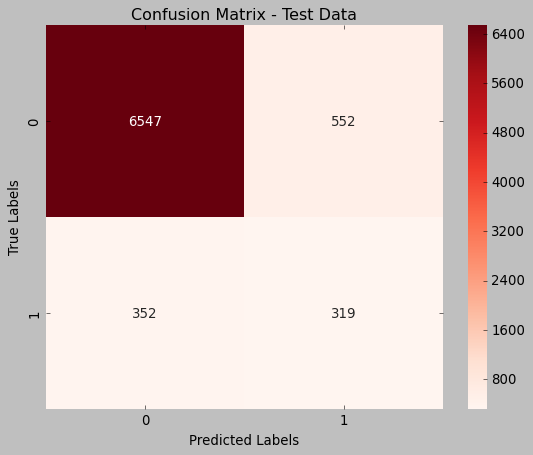

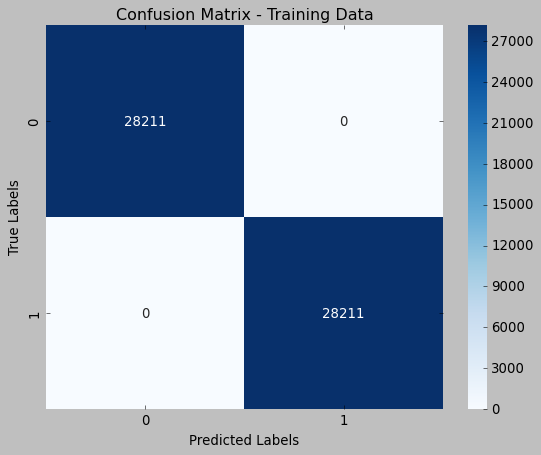

Training Data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Test Data:
Accuracy: 0.8836550836550836
Precision: 0.36624569460390355
Recall: 0.47540983606557374
F1-score: 0.41374837872892345


In [52]:
### Baseline Model Evaluation


def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predict the labels for the training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the evaluation metrics for training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)

    # Calculate the evaluation metrics for test data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    # Plot the confusion matrix for test data
    sns.heatmap(test_cm, annot=True, fmt="d", cmap="Reds")
    plt.title("Confusion Matrix - Test Data")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Plot the confusion matrix for training data
    sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Training Data")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Print the evaluation metrics for training data
    print("Training Data:")
    print("Accuracy:", train_accuracy)
    print("Precision:", train_precision)
    print("Recall:", train_recall)
    print("F1-score:", train_f1)

    # Print the evaluation metrics for test data
    print("\nTest Data:")
    print("Accuracy:", test_accuracy)
    print("Precision:", test_precision)
    print("Recall:", test_recall)
    print("F1-score:", test_f1)
evaluate_model(dt_classifier, X_train_resampled, y_train_resampled, X_test, y_test)

The model achieves perfect performance on the training data, possibly indicating overfitting. On the test data, it demonstrates good accuracy but lower precision, recall, and F1-score, suggesting the need for refinement and tuning to strike a better balance between precision and recall

In [53]:
# Make predictions on the test data
y_pred_proba2 = dt_classifier.predict_proba(X_test)

# Compute the log loss
logloss = log_loss(y_test, y_pred_proba2)

print('Log Loss:', logloss)

Log Loss: 4.018411050321656


### Second Model - Hyperparameter tuning of Decision Tree Classifier
The Parameters of the decision tree can be tuned for the model's better performance in predicting the target class

In [54]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Define the hyperparameters to tune for the Decision Tree Classifier
param_grid_dt = {
    'dt__max_depth': [None, 1, 2],  # Reduce max_depth to prevent overfitting
    'dt__min_samples_split': [35, 17, 30],  # Increase min_samples_split to limit splitting
    'dt__min_samples_leaf': [28, 40, 29, 30],  # Increase min_samples_leaf to control leaf nodes
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_features': ['sqrt', 5, 7], # Further reduce max_features
    'dt__min_impurity_decrease': [0.0, 0.1],
}

# Create a new pipeline with the Decision Tree classifier
pipe_dt = Pipeline([('dt', DecisionTreeClassifier(random_state=1))])

# Perform grid search cross-validation
grid_search_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the training data
grid_search_dt.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters and best score
print("Best Hyperparameters (Decision Tree): ", grid_search_dt.best_params_)
print("Best Score (Decision Tree): ", grid_search_dt.best_score_)

# Cross-validation scores
cv_scores_dt = grid_search_dt.cv_results_['mean_test_score']
# Calculate and print the mean cross-validation accuracy
mean_cv_accuracy_dt = cv_scores_dt.mean()
print("Mean CV Accuracy (Decision Tree):", mean_cv_accuracy_dt)


Best Hyperparameters (Decision Tree):  {'dt__criterion': 'entropy', 'dt__max_depth': None, 'dt__max_features': 7, 'dt__min_impurity_decrease': 0.0, 'dt__min_samples_leaf': 28, 'dt__min_samples_split': 35}
Best Score (Decision Tree):  0.8723547030847539
Mean CV Accuracy (Decision Tree): 0.5963219990331621


In [55]:
### Model Evaluation

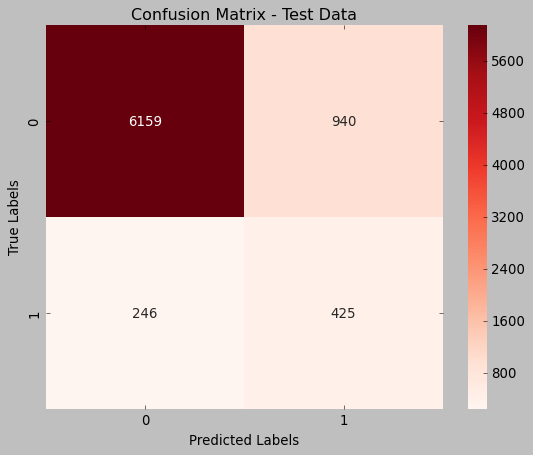

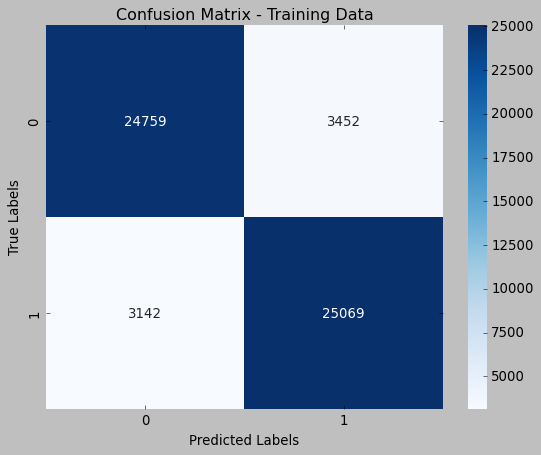

Training Data:
Accuracy: 0.8831306937010386
Precision: 0.8789663756530276
Recall: 0.8886250044308958
F1-score: 0.8837693012761757

Test Data:
Accuracy: 0.8473616473616473
Precision: 0.31135531135531136
Recall: 0.6333830104321908
F1-score: 0.4174852652259332


In [56]:
evaluate_model(grid_search_dt.best_estimator_, X_train_resampled, y_train_resampled, X_test, y_test)    

The tuned model maintains a high level of performance on both training and test data, indicating better generalization.
The tuned model achieves a better balance between precision and recall, making it more suitable for real-world applications  
The tuned model performs better than the baseline model because it provides a more balanced trade-off between different evaluation metrics and is less likely to overfit to the training data

In [57]:
# Make predictions on the test data
y_pred_proba2 = grid_search_dt.best_estimator_.predict_proba(X_test)

# Compute the log loss
logloss = log_loss(y_test, y_pred_proba2)

print('Log Loss:', logloss)

Log Loss: 0.5642157056897168


The log loss of the tuned model (0.5) is significantly lower than that of the baseline model (4.0). This indicates that the tuned model provides much better probability estimates and is more confident in its predictions compared to the baseline model    

This will be the model used for the prediction as it has high accuracy, lower log loss and does not overfit compared to the baseline model.

#### Most important Features

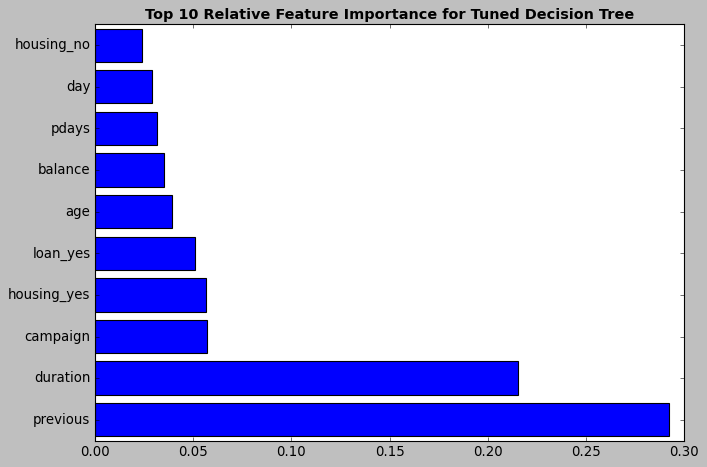

In [58]:
# Get the trained Decision Tree model from the pipeline
dt_model = grid_search_dt.best_estimator_.named_steps['dt']

# Get the feature importances from the Decision Tree model
feature_importance_dt = dt_model.feature_importances_
# Get the names of the features
feature_names_dt = X_final.columns.tolist()

# Plot the top feature importances using the plot_top_feature_importance_tree function
plot_top_feature_importance_tree(feature_importance_dt, feature_names_dt, top_n=10, model_name='Tuned Decision Tree')
